# Build a Pipeline with Classic Models 

In [1]:
#workflow and statistics
import pandas as pd
import numpy as np
import matplotlib as matplotlib
import matplotlib.pyplot as plt

#for showing missing values
import missingno as msno

#visualisation
import seaborn as sns

#natural language processing toolkit
import nltk
import string
from nltk.corpus import stopwords  # removes useless words
from nltk.stem.lancaster import LancasterStemmer  #converts the words to base form; aggressive
from nltk.stem import porter
from nltk.stem.util import suffix_replace, prefix_replace
from nltk.stem.api import StemmerI
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')

#accessing google cloud storage
#from google.cloud import storage
#from io import BytesIO
#client = storage.Client()
#bucket = "bilderkennung_nf_2020"

#building baseline classifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#evaluation metrics
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, recall_score, precision_score

# Grid search cross validation
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/student/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
train = pd.read_csv('./jigsaw-toxic-comment-train.csv')

In [3]:
train.shape

(223549, 8)

In [4]:
data_ = {'toxic':[11.4], 'non-toxic':[88.9]}

In [5]:
rel_dist = pd.DataFrame.from_dict(data_)
rel_dist.transpose()

,0
toxic,11.4
non-toxic,88.9


<Figure size 720x432 with 0 Axes>

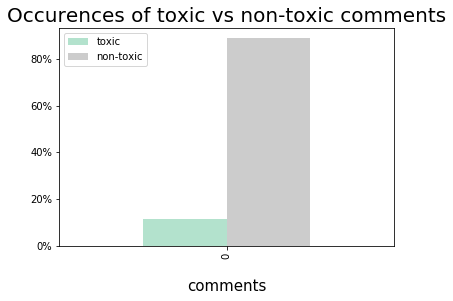

In [6]:
import matplotlib.ticker as mtick

plt.figure(1,figsize=(10,6))
ax = rel_dist.plot(kind='bar', colormap='Pastel2')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title("Occurences of toxic vs non-toxic comments",fontsize=20)
#plt.ylabel('number of Occurrences', fontsize=15,labelpad=20)
plt.xlabel('comments', fontsize=15,labelpad=20)
plt.show()

**Prepare Data**

In [7]:
def remove_punctuation(text):
    '''a function for removing punctuation'''
    import string
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)
train['comment_text'] = train['comment_text'].apply(remove_punctuation)

In [8]:
sw=stopwords.words('english')
def removesw(text):
    '''a function for removing the stopword'''
    # removing the stop words and lowercasing the selected words
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    # joining the list of words with space separator
    return " ".join(text)
train['comment_text'] = train['comment_text'].apply(removesw)

In [9]:
stemmer = SnowballStemmer("english")

def stemming(text):    
    '''a function which stems each word in the given text'''
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text) 
train['comment_text'] = train['comment_text'].apply(stemming)

**Pipeline**

In [10]:
X = train[['comment_text']]
Y = train['toxic']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin

class TextSelector(BaseEstimator, TransformerMixin):
    def __init__(self, field):
        self.field = field
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.field]
    
#class NumberSelector(BaseEstimator, TransformerMixin):
#    def __init__(self, field):
#        self.field = field
#    def fit(self, X, y=None):
#        return self
#    def transform(self, X):
#        return X[[self.field]]

In [12]:
import nltk

def Tokenizer(str_input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    porter_stemmer=nltk.PorterStemmer()
    words = [porter_stemmer.stem(word) for word in words]
    return words

After vectorizing the text, if we use the XGBoost classifier we need to add the TruncatedSVD transformer to the pipeline. Its role is to perform linear dimensionality reduction by means of truncated singular value decomposition (SVD). It works on tf-idf matrices generated by sklearn doing what’s called latent semantic analysis (LSA).

In [13]:
import re
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

classifier = Pipeline([
    ('features', FeatureUnion([
        ('comment_text', Pipeline([
            ('colext', TextSelector('comment_text')),
            ('tfidf', TfidfVectorizer(tokenizer=Tokenizer,
                     min_df=.0025, max_df=0.25, ngram_range=(1,3))),
            ('svd', TruncatedSVD(algorithm='randomized', n_components=300)), #for XGB
        ]))
    ])),
    ('clf', XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.1)),
    #('clf', RandomForestClassifier()),
    #('clf', RandomForestClassifier()),
    #('clf', RandomForestClassifier()),
    
    ])

The reason we use a FeatureUnion is to allow us to combine different Pipelines that run on different features of the training data.

In [14]:
classifier.fit(X_train, y_train)
preds = classifier.predict(X_test)

In [15]:
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix

print("Accuracy:", accuracy_score(y_test, preds))
print("Precision:", precision_score(y_test, preds))
print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))

Accuracy: 0.9424921271113655
Precision: 0.8283420808891633
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     50547
           1       0.83      0.50      0.63      5341

    accuracy                           0.94     55888
   macro avg       0.89      0.75      0.80     55888
weighted avg       0.94      0.94      0.94     55888

[[49991   556]
 [ 2658  2683]]
